In [1]:
# ! pip install zuko

In [2]:
import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [6]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Jets

In [7]:
from jetnet.datasets import JetNet, TopTagging

particle_data, jet_data = JetNet.getData(jet_type=["q"], data_dir="../data/", num_particles=30)

[██████████████████████████████████████████████████] 100%


In [8]:
q_jets_rearranged = particle_data

In [22]:
x = torch.Tensor(q_jets_rearranged[:, :, :3])
mask = torch.Tensor(q_jets_rearranged[:, :, 3:])

mask[mask > 0] = 1
mask[mask < 0] = 0

## Flow matching with transformer

In [35]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch import Tensor
from torch.distributions import Normal
from tqdm import tqdm
from typing import *

from zuko.utils import odeint
from models.transformer import Transformer

In [36]:
net = Transformer(emb=128, heads=2, depth=3, seq_length=30, mask=False)

In [42]:
# Test transformer
x_test = x[:64]
x_emb = nn.Linear(3, 128)(x_test)
net(x_emb).shape

torch.Size([64, 30, 128])

In [78]:
class CNF(nn.Module):
    def __init__(
        self,
        features: int,
        frequencies: int = 3,
        embedding_dim: int = 128,
        **kwargs
    ):
        super().__init__()
        
        

        self.net = Transformer(emb=embedding_dim, mask=False, **kwargs)
        self.emb = nn.Linear(features + 2 * frequencies, embedding_dim)
        self.demb = nn.Linear(embedding_dim, features)
        
        self.register_buffer('frequencies', 2 ** torch.arange(frequencies) * torch.pi)

    def forward(self, t: Tensor, x: Tensor) -> Tensor:
        t = self.frequencies * t[..., None]
        t = torch.cat((t.cos(), t.sin()), dim=-1)
        t = t.expand(*x.shape[:-1], -1)
        
        x = torch.cat((t, x), dim=-1)
        
        x = self.emb(x)
        x = self.net(x)
        x = self.demb(x)
        
        return x

    def encode(self, x: Tensor) -> Tensor:
        return odeint(self, x, 0.0, 1.0, phi=self.parameters())

    def decode(self, z: Tensor) -> Tensor:
        return odeint(self, z, 1.0, 0.0, phi=self.parameters())

    def log_prob(self, x: Tensor) -> Tensor:
        I = torch.eye(x.shape[-1]).to(x)
        I = I.expand(x.shape + x.shape[-1:]).movedim(-1, 0)

        def augmented(t: Tensor, x: Tensor, ladj: Tensor) -> Tensor:
            with torch.enable_grad():
                x = x.requires_grad_()
                dx = self(t, x)

            jacobian = torch.autograd.grad(dx, x, I, is_grads_batched=True, create_graph=True)[0]
            trace = torch.einsum('i...i', jacobian)

            return dx, trace * 1e-2

        ladj = torch.zeros_like(x[..., 0])
        z, ladj = odeint(augmented, (x, ladj), 0.0, 1.0, phi=self.parameters())

        return Normal(0.0, z.new_tensor(1.0)).log_prob(z).sum(dim=-1) + ladj * 1e2


class FlowMatchingLoss(nn.Module):
    def __init__(self, v: nn.Module):
        super().__init__()

        self.v = v

    def forward(self, x: Tensor) -> Tensor:
        t = torch.rand_like(x[..., 0]).unsqueeze(-1)
        z = torch.randn_like(x)
        y = (1 - t) * x + (1e-4 + (1 - 1e-4) * t) * z
        u = (1 - 1e-4) * z - x

        return (self.v(t.squeeze(-1), y) - u).square().mean()

In [79]:
kwargs = {"heads":2, "depth":3, "seq_length":30}
flow = CNF(features=3, **kwargs)

# Training
loss = FlowMatchingLoss(flow)

In [ ]:
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
batch_size = 64
n_iter = 5000

for epoch in tqdm(range(n_iter)):
    subset = torch.randint(0, len(x), (batch_size,))
    optimizer.zero_grad()
    loss(x[subset]).backward()
    optimizer.step()

## Generation

In [69]:
n_samples = 100
n_particles = 30

with torch.no_grad():
    z = torch.randn(n_samples, n_particles, 3)
    x_samples = flow.decode(z).numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 37.49it/s]
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: CMU Serif


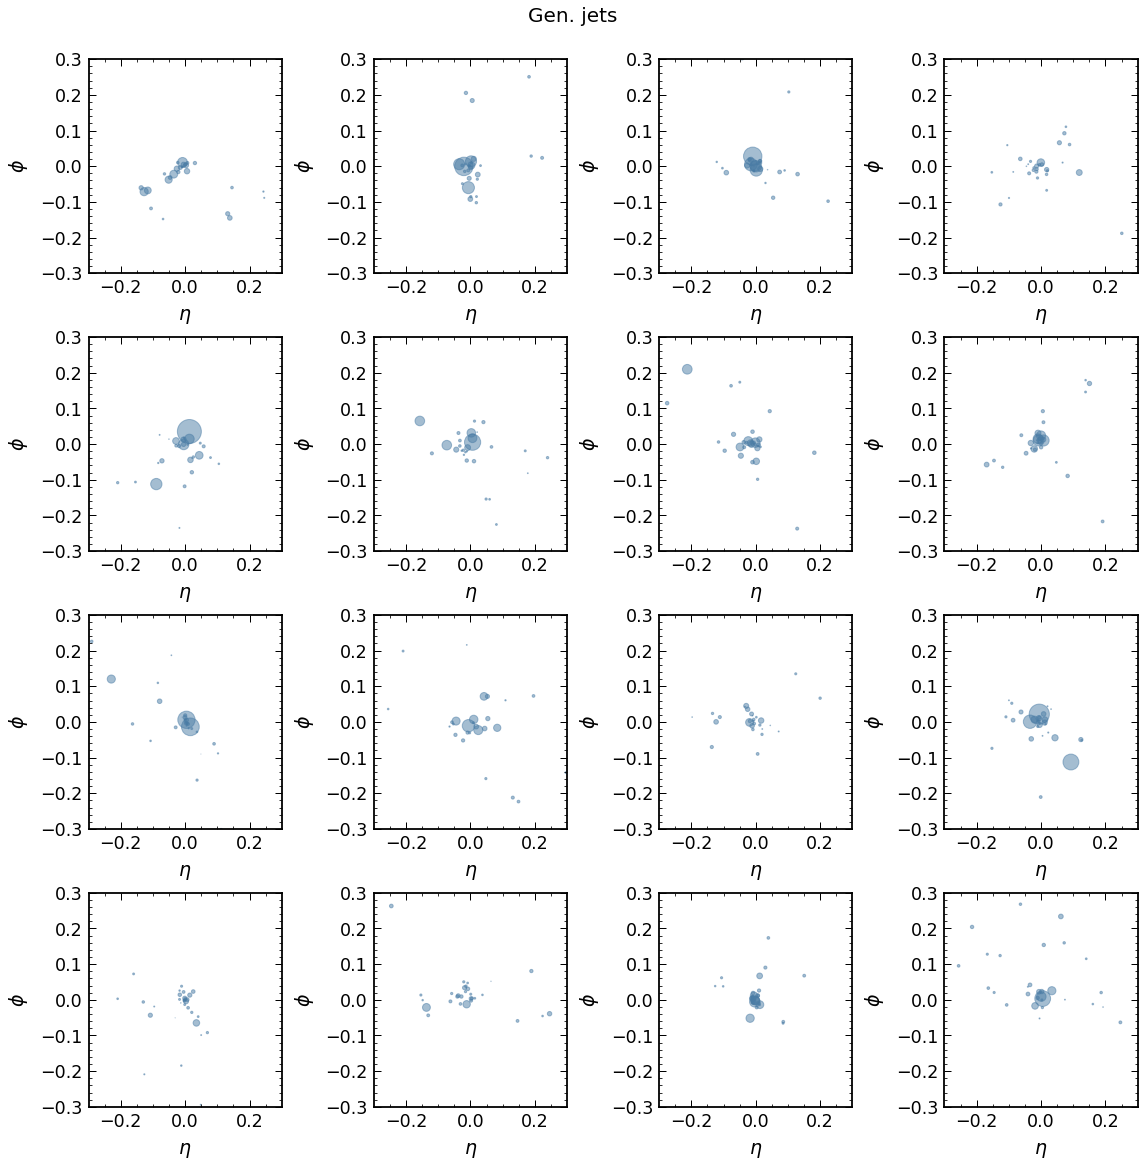

In [71]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])
        
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * np.abs(x_samples[i, :, 2]), alpha=0.5, color=cols_default[1]) 
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()